In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import os
from PIL import Image

In [ ]:
#Dataset personalizado reutilizamos el mismo
class YOLOClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith(".jpg")]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_file)
        label_path = os.path.join(self.labels_dir, img_file.replace(".jpg", ".txt"))
        
        image = Image.open(img_path).convert("RGB")
        
        with open(label_path, "r") as f:
            first_line = f.readline().strip()
            class_id = int(first_line.split()[0])
        
        if self.transform:
            image = self.transform(image)
        
        return image, class_id

In [ ]:
#Configuración y data argumentada
data_dir = "../../datasets/processed/images"
img_size = 128
batch_size = 32
epochs = 10
lr = 0.0005

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", device)

# Data augmentation solo en train
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Datasets
train_dataset = YOLOClassificationDataset(
    images_dir=f"{data_dir}/train/images",
    labels_dir=f"{data_dir}/train/labels",
    transform=train_transform
)

val_dataset = YOLOClassificationDataset(
    images_dir=f"{data_dir}/val/images",
    labels_dir=f"{data_dir}/val/labels",
    transform=val_transform
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train: {len(train_dataset)} imágenes")
print(f"Val: {len(val_dataset)} imágenes")

Usando: cpu
Train: 1468 imágenes
Val: 164 imágenes


In [ ]:
# Modelo preentrenado ResNet18
num_classes = 2  #cámbialo si tienes más clases

model = models.resnet18(weights="IMAGENET1K_V1")  # usar pesos preentrenados
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)
print("Modelo cargado:", model.__class__.__name__)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Sebastian/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:04<00:00, 10.2MB/s]

Modelo cargado: ResNet


In [5]:
#loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [6]:
#Entrenamiento y validación
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    #entrenamiento
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    #validación
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)
    
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | Val Loss: {val_losses[-1]:.4f}, Acc: {val_accs[-1]:.4f}")

Epoch 1/10 | Train Loss: 0.8409, Acc: 0.5484 | Val Loss: 1.0845, Acc: 0.5549
Epoch 2/10 | Train Loss: 0.6870, Acc: 0.5681 | Val Loss: 0.7480, Acc: 0.5671
Epoch 3/10 | Train Loss: 0.6703, Acc: 0.6076 | Val Loss: 0.6869, Acc: 0.5610
Epoch 4/10 | Train Loss: 0.6713, Acc: 0.6001 | Val Loss: 0.7268, Acc: 0.5488
Epoch 5/10 | Train Loss: 0.6584, Acc: 0.6097 | Val Loss: 0.7289, Acc: 0.5427
Epoch 6/10 | Train Loss: 0.6554, Acc: 0.6172 | Val Loss: 0.7821, Acc: 0.4817
Epoch 7/10 | Train Loss: 0.6558, Acc: 0.6042 | Val Loss: 0.7863, Acc: 0.5244
Epoch 8/10 | Train Loss: 0.6459, Acc: 0.6301 | Val Loss: 0.7500, Acc: 0.5549
Epoch 9/10 | Train Loss: 0.6295, Acc: 0.6458 | Val Loss: 0.7095, Acc: 0.5732
Epoch 10/10 | Train Loss: 0.6212, Acc: 0.6478 | Val Loss: 0.7571, Acc: 0.5854


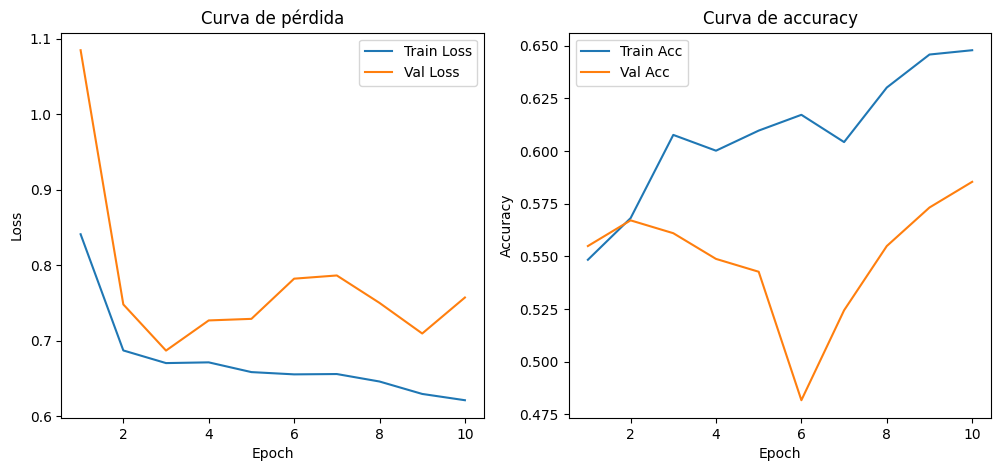

In [7]:
#Graficos
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Curva de pérdida")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), train_accs, label="Train Acc")
plt.plot(range(1, epochs+1), val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Curva de accuracy")
plt.legend()

plt.show()

In [8]:
#Guardamos modelo mejorado
torch.save(model.state_dict(), "../../models/saved/resnet18_experiment.pth")
print("✅ Modelo guardado en: ../../models/saved/resnet18_experiment.pth")

✅ Modelo guardado en: ../../models/saved/resnet18_experiment.pth
